# 0. Load parameters


In [56]:
# | tags: [parameters]
subject = "101"

In [57]:
# | tags: [parameters]
# Injected Parameters
subject = 101

In [58]:
import os
import mne
from pathlib import Path
from spectral.utils import print_date_time, read_parameters, config_project
from spectral.preproc import load_data, zapline_clean, get_bad_lof
from spectral.preproc import detrending, apply_pyprep, get_bad_channels
from spectral.viz import plot_step, plot_bad_channels
from spectral.viz import plot_epochs

import numpy as np

from spectral.ica import (
    compute_ica,
    label_components_ica,
    plot_ica_components,
    plot_removed_components,
)

mne.viz.set_browser_backend("matplotlib")
# mne.viz.set_browser_backend("qt")
mne.set_config("MNE_BROWSER_THEME", "light")
# matplotlib.use("Agg")

config = read_parameters()
my_paths = config_project(subject)

project_path = my_paths["project_path"]
raw_preproc_path = my_paths["raw_preproc_path"]
print(raw_preproc_path)
Path(raw_preproc_path).mkdir(parents=True, exist_ok=True)

figures_path = my_paths["figures_path"]

print_date_time()

/Users/daniel/PhD/Projects/psd-path/analysis/data/raw/sub-101/
2024-04-24 00:26:05


This file contains preprocessing files after downsampling them.


# 1. Preprocess raw data


In [53]:
fline = 50
h_freq = 40
notch_freq = 50

filter_params = {
    "l_freq": 0.1,
    "h_freq": h_freq,
    "h_trans_bandwidth": "auto",
    "fir_window": "hamming",
    "fir_design": "firwin2",
    "phase": "zero",
    "picks":['ecg', 'eeg']
}

raw = load_data(subject, project_path=project_path).resample(250)

raw_filtered = (
    raw.copy()
    .crop(tmin=0, tmax=300, include_tmax=True)
    .filter(**filter_params)
        .notch_filter(
        freqs=[notch_freq],
        phase="zero",
        method="iir"
    )
)

Loading data from /Users/daniel/PhD/Projects/psd-path/data/raw/BIDS/sub-101/ses-01/eeg/sub-101_ses-01_task-rest_eeg.set
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 16501 samples (66.004 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.3s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

IIR filter parameters
---------------------
Butterworth bandstop zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 49.38, 50.62 Hz: -6.02, -6.02 dB



In [54]:
pyprep = True

if pyprep:
    bad_channels_by_ransac = apply_pyprep(
        raw_filtered, output="dict", as_dict=True
    )
else:
    bad_channels_by_ransac = get_bad_channels(raw_filtered)

raw_pyprep = raw_filtered.copy()
raw_pyprep.info["bads"].extend(bad_channels_by_ransac["bad_all"])


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 413 samples (3.304 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Executing RANSAC
This may take a while, so be patient...
Finding optimal chunk size : 244
Total # of chunks: 1
Current chunk:
1

RANSAC done!


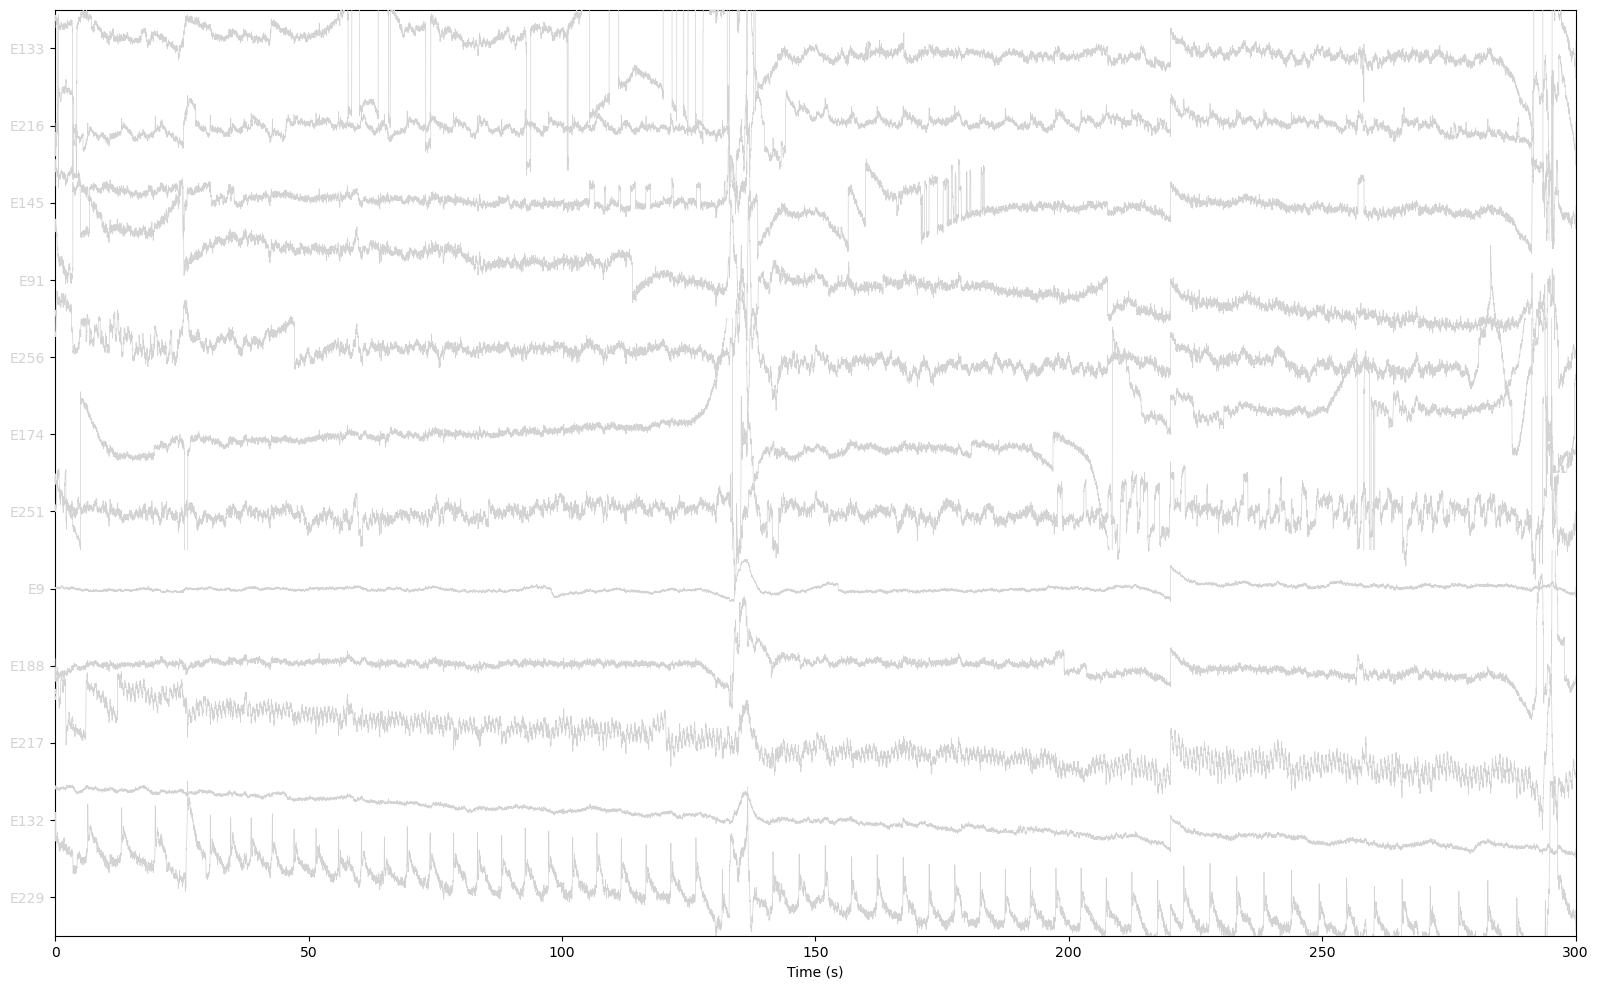

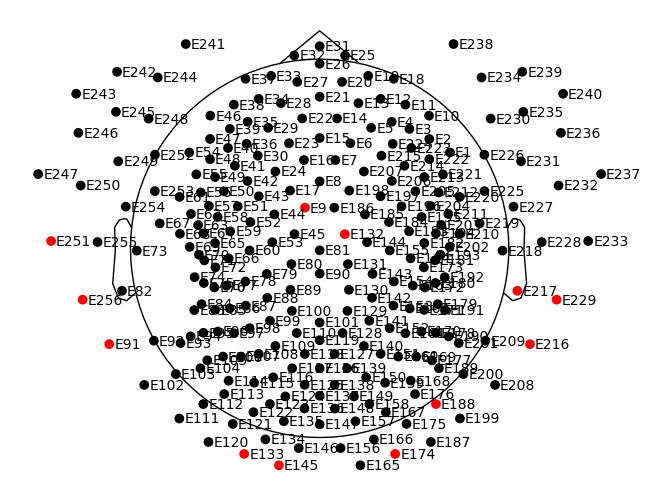

Writing /Users/daniel/PhD/Projects/psd-path/analysis/101_filtered_raw.fif
Closing /Users/daniel/PhD/Projects/psd-path/analysis/101_filtered_raw.fif
[done]


In [60]:
_ = plot_bad_channels( raw_pyprep, subject, figures_path=figures_path)
raw_pyprep.save(f'{project_path}/analysis/sub-{subject}_filtered_raw.fif', overwrite=True)

Not setting metadata
85 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 85 events and 1251 original time points ...
0 bad epochs dropped
fitting finished
Dropped 14 epochs: 0, 6, 16, 17, 36, 37, 38, 39, 40, 62, 73, 82, 83, 84


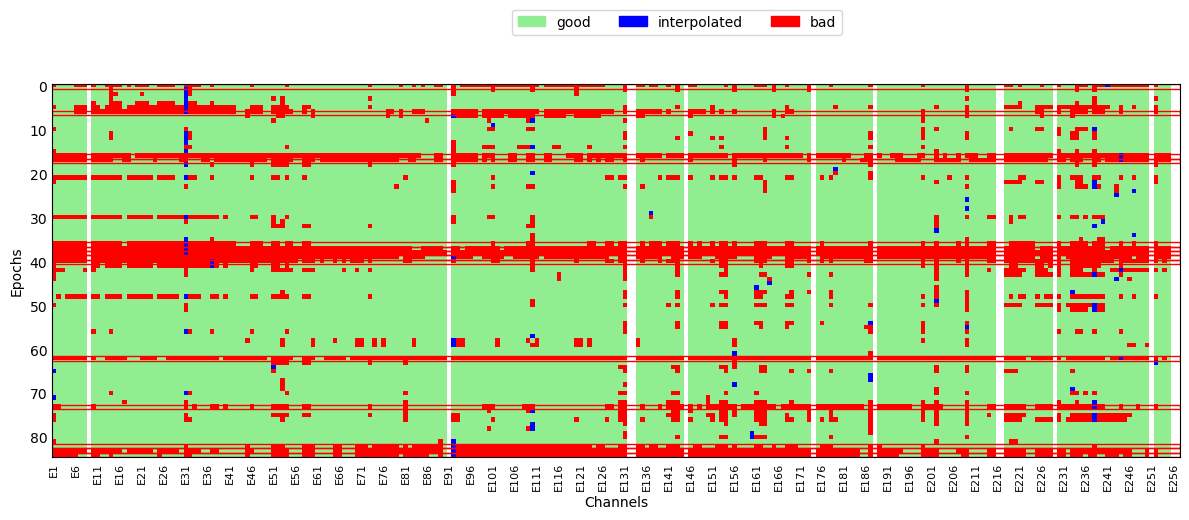

Additional 14 bad channels found:['E31', 'E53', 'E110', 'E131', 'E143', 'E154', 'E187', 'E199', 'E202', 'E209', 'E230', 'E233', 'E234', 'E238']


In [61]:
from spectral.epochs import create_epochs, get_reject_log

#raw_annotated = raw_pyprep.copy()
epochs = create_epochs(raw_pyprep, overlap=1.5)

reject_log = get_reject_log(epochs, resample=125, n_interpolate=[1], consensus=[0.35])
reject_plot = reject_log.plot("vertical")


# Drop channels with more than 40% bad epochs
BADS_THRESHOLD = 0.35

bads = np.logical_or(reject_log.labels == 1, reject_log.labels == 2)

bad_channel = bads.mean(axis=0)
# print(bad_channel)
epochs.info
channel_names = epochs.info["ch_names"]
bad_channels_by_epochs = [
    name for name, value in zip(channel_names, bad_channel) if value > BADS_THRESHOLD
]
print(
    f"Additional {len(bad_channels_by_epochs)} bad channels found:{
        bad_channels_by_epochs}"
)

#epochs.info["bads"].extend(bad_channels_by_epochs)

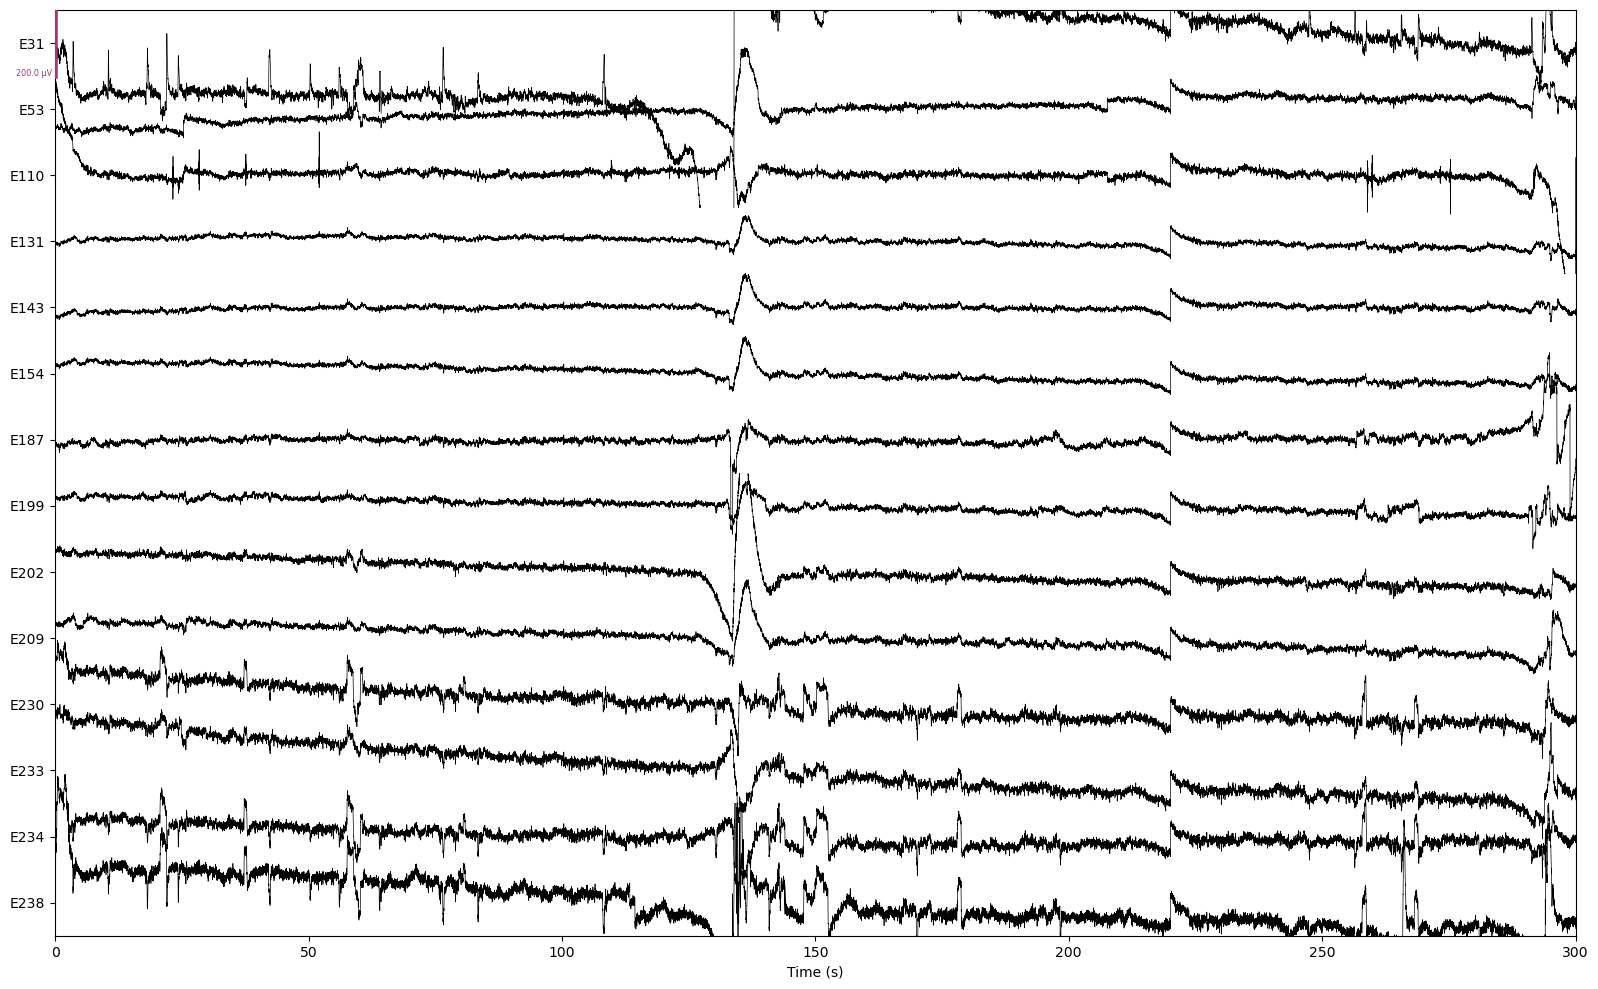

In [8]:
bad_channel_plot_additional = raw_pyprep.plot(
        picks=bad_channels_by_epochs,
        duration=300.0,
        scalings=dict(eeg=1e-4),
        show_scrollbars=False,
    )

In [62]:
epochs_good = epochs[~reject_log.bad_epochs]
ica = compute_ica(epochs_good, n_components=0.99, method="picard")


Fitting ICA to data using 244 channels (please be patient, this may take a while)
Selecting by explained variance: 51 components
Fitting ICA took 10.8s.


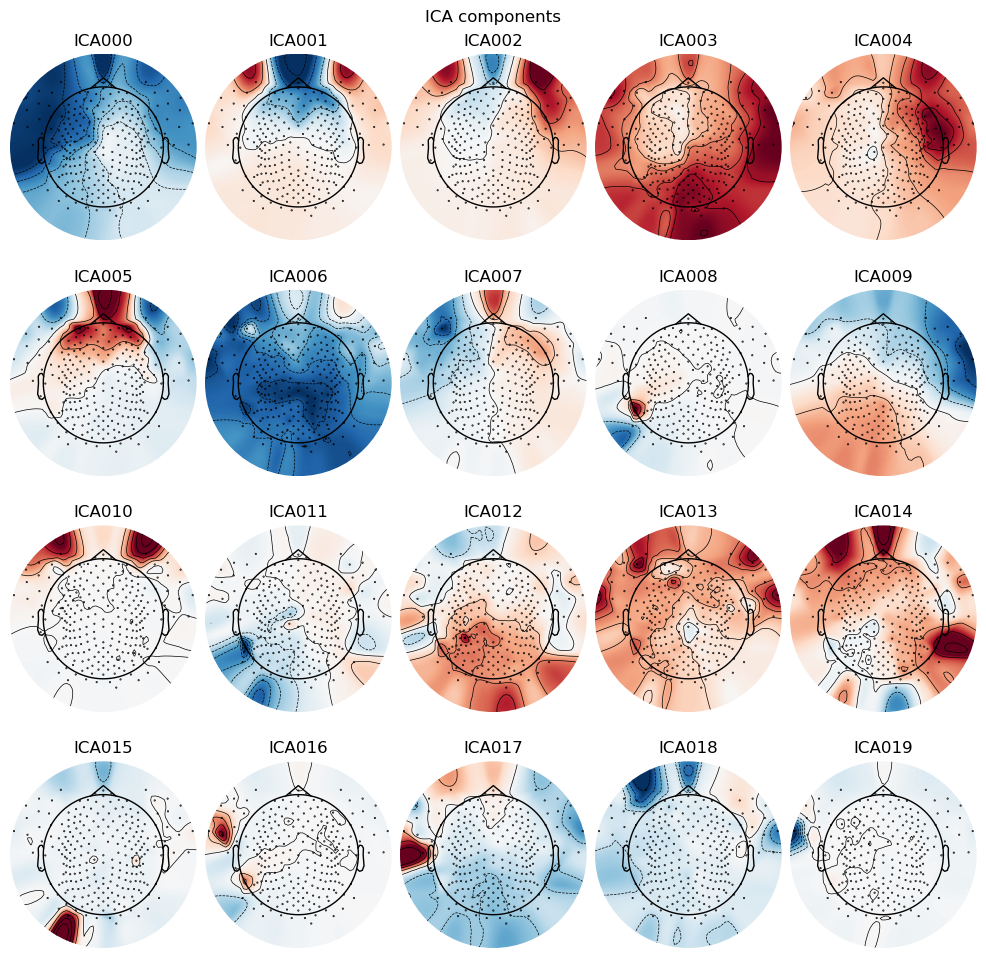

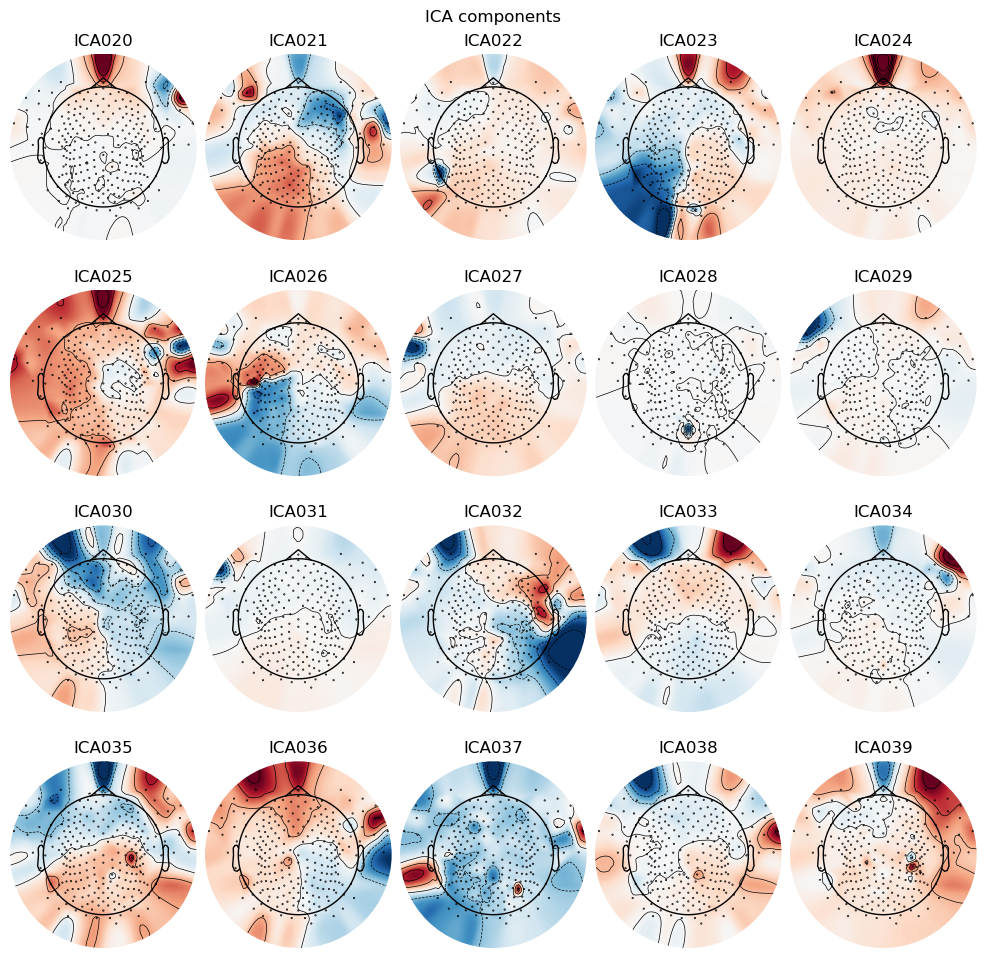

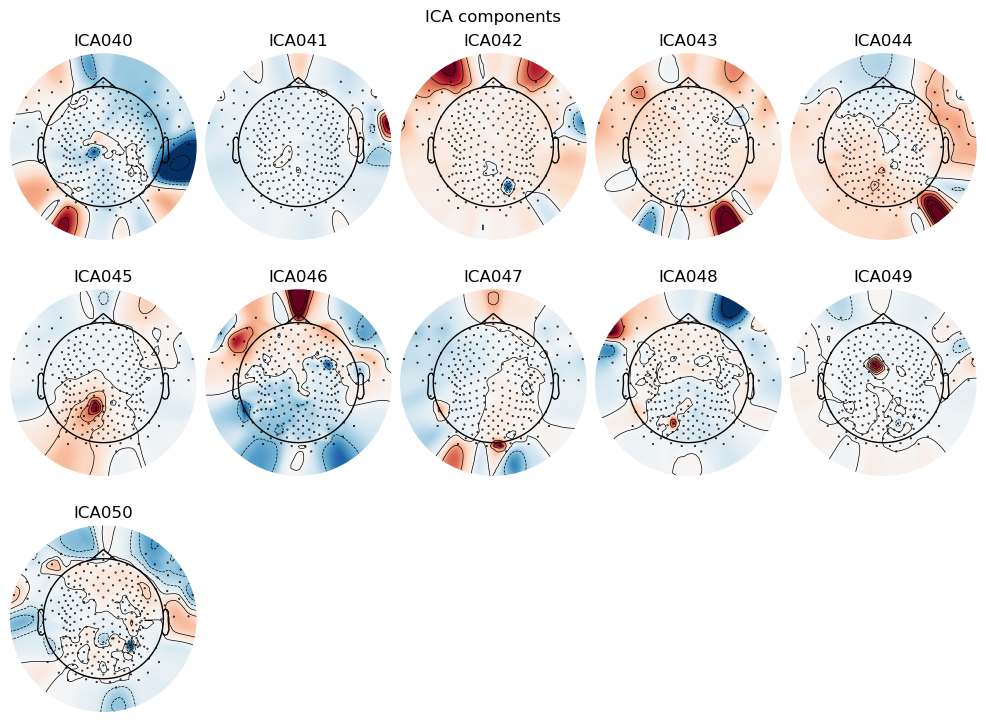

In [63]:
ica_plot_components = ica.plot_components()

Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated


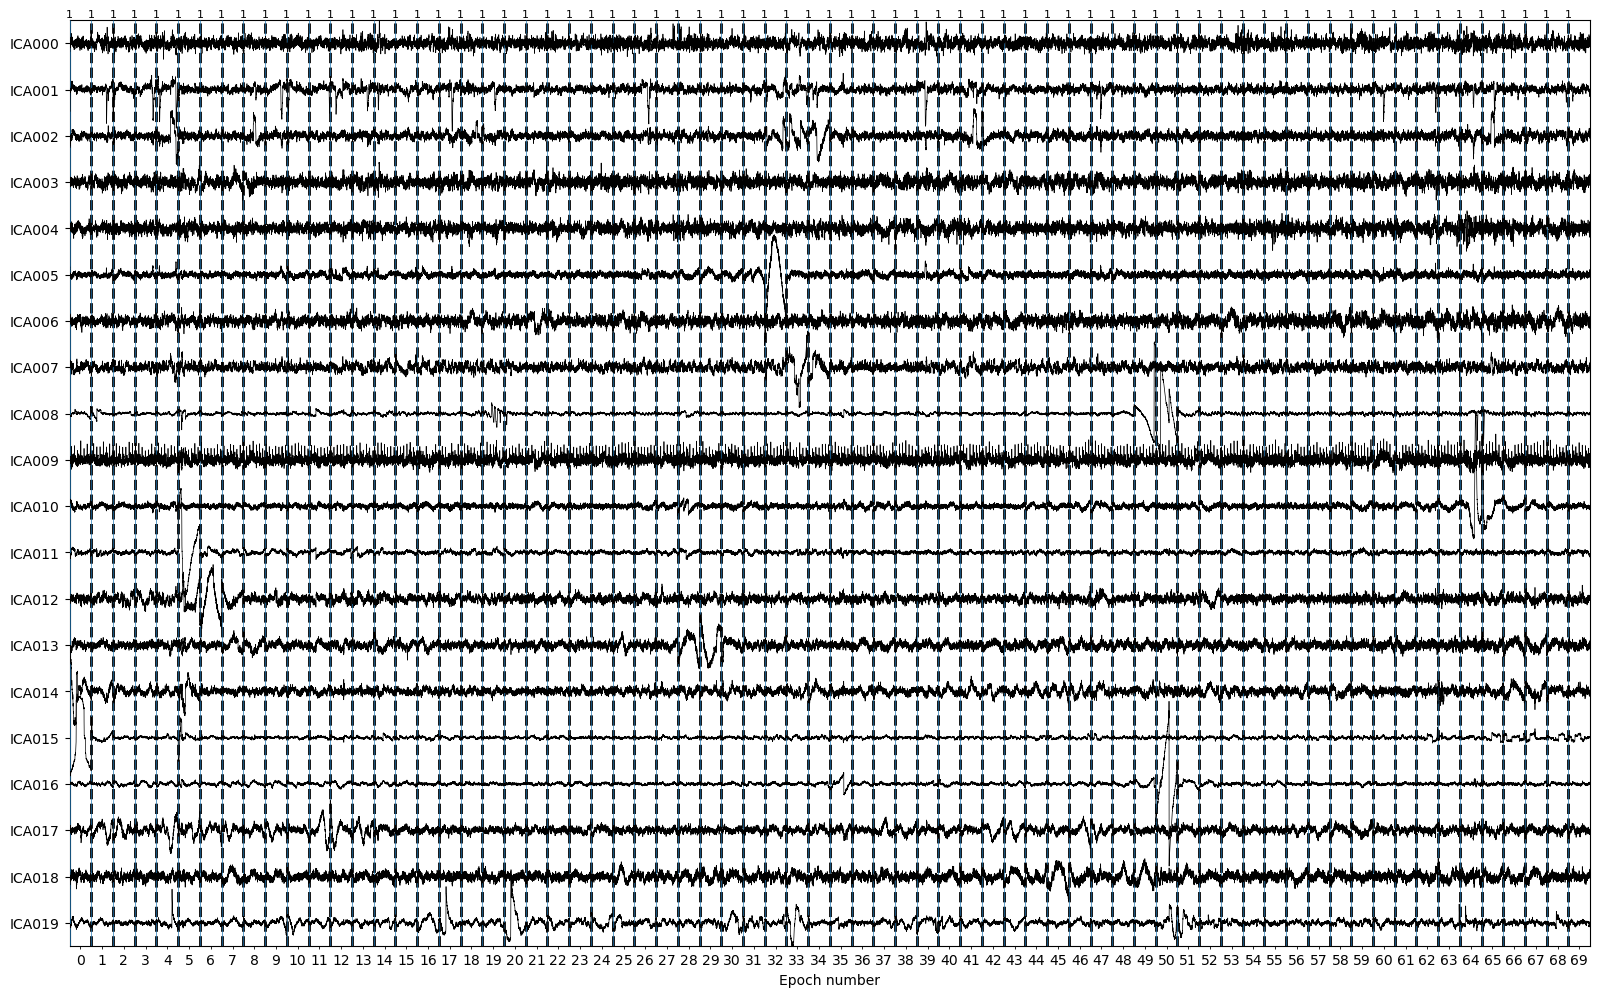

Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated


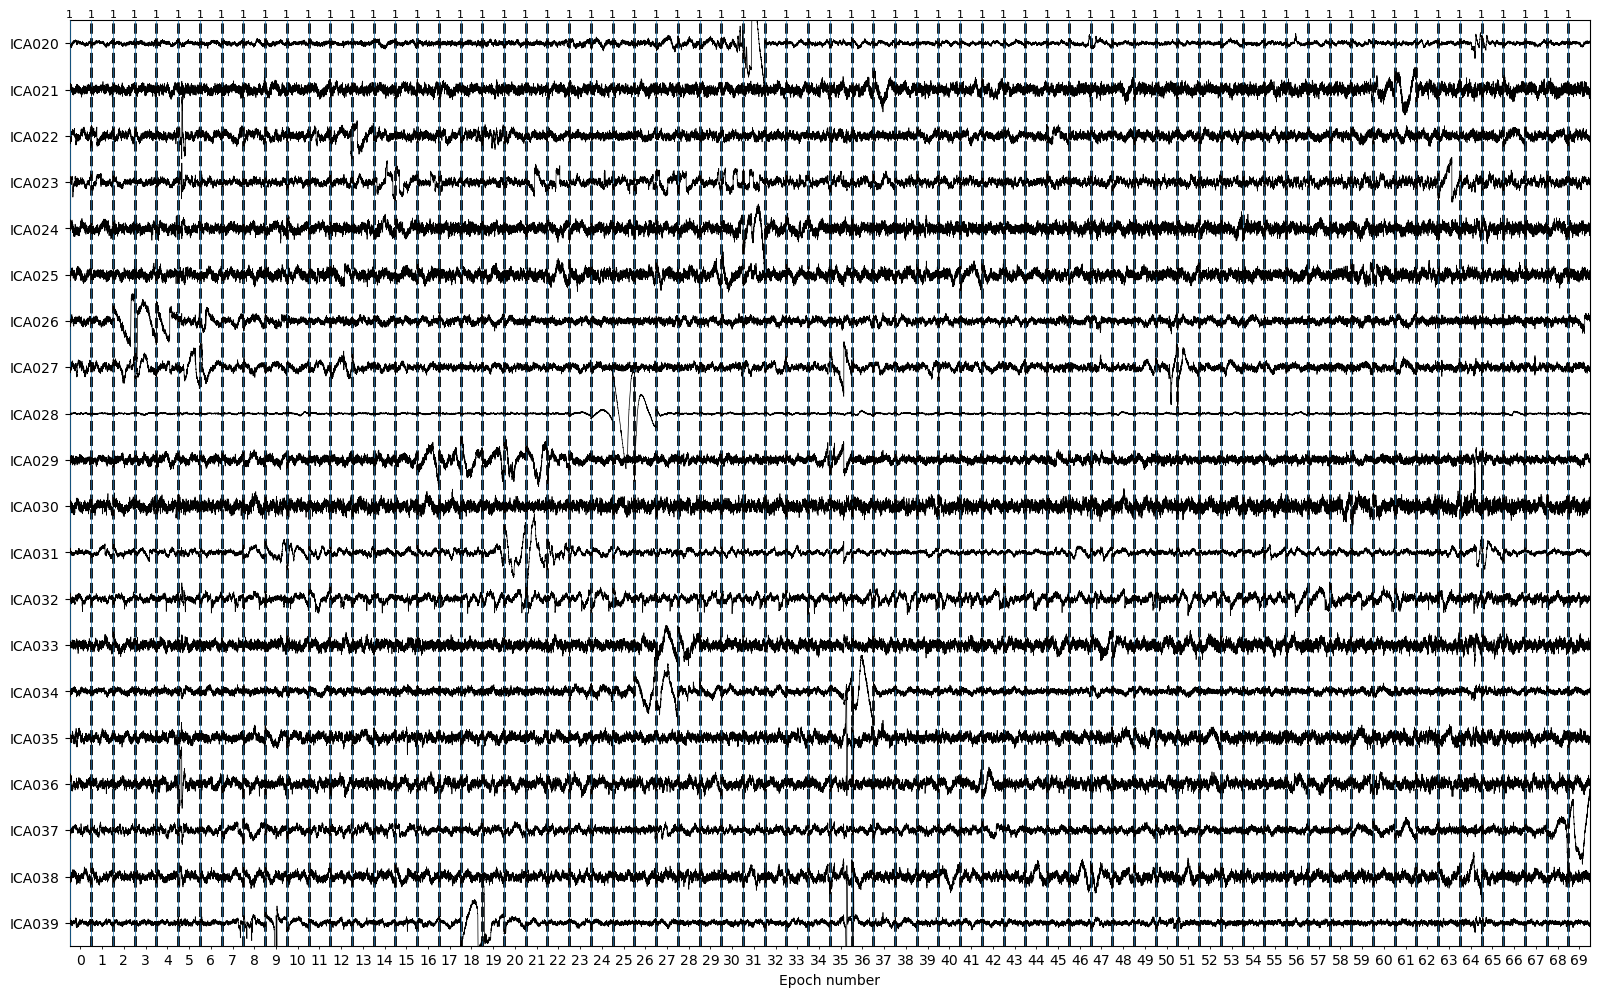

Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated


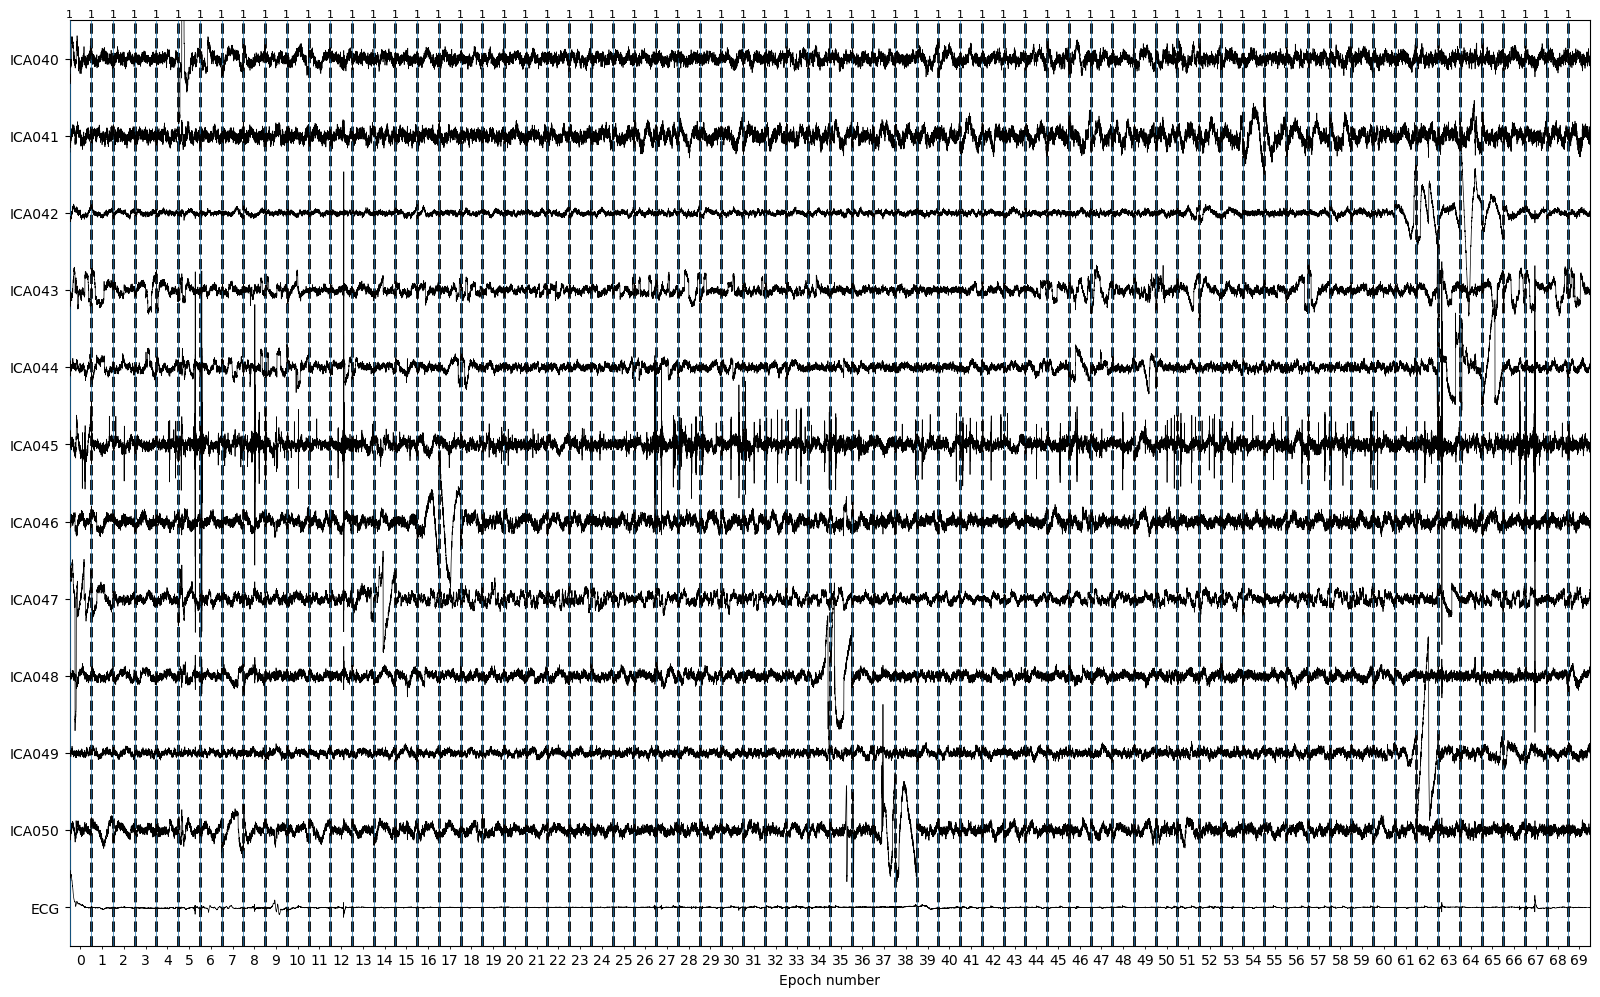

In [64]:
chunk_size = 20
chunks = [range(i, min(i + chunk_size, ica.n_components_)) for i in range(0, ica.n_components_, chunk_size)]

for chunk in chunks:
    ica_plot = ica.plot_sources(
                    epochs_good,
                    picks=chunk,
                    show_scrollbars=False,
                    start=0,
                    stop=len(epochs_good) - 1,
                )

In [25]:
from mne.preprocessing import ICA

ica.save(f'{project_path}/analysis/sub-{subject}_my_ica_model-ica.fif', overwrite=True)
epochs_good.save(f'{project_path}/analysis/sub-{subject}_good_epochs-epo.fif', overwrite=True)

Overwriting existing file.
Writing ICA solution to /Users/daniel/PhD/Projects/psd-path/analysis/101_my_ica_model-ica.fif...


In [29]:
ica_loaded = mne.preprocessing.read_ica(f'{project_path}/analysis/sub-{subject}_my_ica_model-ica.fif')
epochs_good =  mne.read_epochs(f'{project_path}/analysis/sub-{subject}_good_epochs-epo.fif')


Reading /Users/daniel/PhD/Projects/psd-path/analysis/101_my_ica_model-ica.fif ...


Now restoring ICA solution ...
Ready.
Reading /Users/daniel/PhD/Projects/psd-path/analysis/101_good_epochs-epo.fif ...
    Found the data of interest:
        t =       0.00 ...    5000.00 ms
        0 CTF compensation matrices available
Not setting metadata
71 matching events found
No baseline correction applied
0 projection items activated


In [32]:
from mne_icalabel.gui import label_ica_components

#gui = label_ica_components(epochs_good, ica)


In [ ]:
# ica_plot = ica.plot_sources(eeg_data)
# Exclude blink artifact components (use Fp1 as EOG proxy)
clean_raw = mne.io.read_raw_fif(
    f"{raw_preproc_path}/sub-{subject}_filtered_raw.fif", preload=True
)
# epochs_eog = mne.preprocessing.create_eog_epochs(raw=clean_raw, ch_name="EOG")
# eog_indices, eog_scores = ica.find_bads_eog(epochs_eog, ch_name="E31", threshold=2)
ecg_indices, ecg_scores = ica.find_bads_ecg(
    clean_raw, method="correlation", threshold="auto"
)
# ica.exclude = np.argwhere(abs(eog_scores) > 0.5).ravel().tolist()
if ecg_indices:
    # barplot of ICA component "EOG match" scores
    ica.plot_properties(clean_raw, picks=ecg_indices)

    # plot ICs applied to raw data, with ECG matches highlighted
    ecg_plot = ica.plot_sources(
        clean_raw,
        show_scrollbars=False,
        picks=ecg_indices,
        start=0,
        stop=len(epochs) - 1,
    )

In [39]:
#exclude = [1, 9, 45]
exclude =  []

In [40]:
if exclude:
    ica.exclude = exclude
    epochs_clean_manual = ica.apply(epochs.copy(), exclude=ica.exclude)
    epochs_clean_manual.save(
    f"{project_path}/sub-{subject}_clean_ica-manual-epo.fif", overwrite=True
    )